<a href="https://colab.research.google.com/github/JeanMusenga/PhD-Thesis_2024_Musenga/blob/main/TextCNN_with_GloVe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://chatgpt.com/share/6b20ab3c-04a2-4b5b-b39b-6531835e3571

In [9]:
pip install tensorflow

In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [35]:
import numpy as np

np.random.seed(42) #The random seed helps in the reproduction of the results

# Loading Data

In [ ]:
file_path = './saved_file'
file_path = ('posts.xlsx')
data = pd.read_excel(file_path)

In [17]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2024-08-07 05:22:05--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-08-07 05:22:05--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-08-07 05:22:06--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.2’

gl

In [20]:
ls glove.6B.zip

glove.6B.zip


In [21]:
def load_glove_embeddings(glove_file):
    embeddings_index = {}
    with open(glove_file, encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

In [22]:
# After you downloaded the 'glove.6B.100d.txt' file
glove_file = 'glove.6B.100d.txt'
embeddings_index = load_glove_embeddings(glove_file)
print(f'Found {len(embeddings_index)} word vectors.')

Found 400000 word vectors.


# Preprocess the data

In [23]:
# Preprocess the data
X = data['Question_body']
y = data['Label']

# Encode labels

In [24]:
# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data into training and testing sets

In [25]:

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)


In [26]:
import numpy as np

# Load GloVe embeddings
def load_glove_embeddings(glove_file):
    embeddings_index = {}
    with open(glove_file, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

# Tokenize Text and Create Embedding Matrix

In [27]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenize the text data
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

# Create the embedding matrix

In [28]:
# Create the embedding matrix
embedding_dim = 100
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Pad the sequences
max_length = 100
X_train_padded = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=max_length)
X_test_padded = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=max_length)

# Create and Train TextCNN Model

In [29]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, concatenate

# Create the TextCNN model
def create_text_cnn_model(vocab_size, embedding_dim, max_length, embedding_matrix):
    inputs = Input(shape=(max_length,))
    embedding = Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=max_length, trainable=False)(inputs)

    conv1 = Conv1D(128, 3, activation='relu')(embedding)
    pool1 = MaxPooling1D(pool_size=2)(conv1)

    conv2 = Conv1D(128, 4, activation='relu')(embedding)
    pool2 = MaxPooling1D(pool_size=2)(conv2)

    conv3 = Conv1D(128, 5, activation='relu')(embedding)
    pool3 = MaxPooling1D(pool_size=2)(conv3)

    concatenated = concatenate([pool1, pool2, pool3], axis=1)
    flatten = Flatten()(concatenated)
    dense1 = Dense(128, activation='relu')(flatten)
    dropout = Dropout(0.5)(dense1)
    outputs = Dense(1, activation='sigmoid')(dropout)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

vocab_size = len(word_index) + 1


In [30]:
# Create the model
text_cnn_model = create_text_cnn_model(vocab_size, embedding_dim, max_length, embedding_matrix)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [31]:
# Display the model summary
text_cnn_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 100)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 100, 100)       │      7,152,400 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 98, 128)        │         38,528 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_1 (Conv1D)         │ (None, 97, 128)        │         51,328 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_2 (Conv1D)         │ (None, 96, 128)        │         64,128 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d             │ (None, 49, 128)        │              0 │ conv1d[0][0]           │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_1           │ (None, 48, 128)        │              0 │ conv1d_1[0][0]         │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_2           │ (None, 48, 128)        │              0 │ conv1d_2[0][0]         │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 145, 128)       │              0 │ max_pooling1d[0][0],   │
│                           │                        │                │ max_pooling1d_1[0][0], │
│                           │                        │                │ max_pooling1d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 18560)          │              0 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 128)            │      2,375,808 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 128)            │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 1)              │            129 │ dropout[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 9,682,321 (36.94 MB)

 Trainable params: 2,529,921 (9.65 MB)

 Non-trainable params: 7,152,400 (27.28 MB)

In [32]:
# Train the model
history = text_cnn_model.fit(X_train_padded, y_train, epochs=10, batch_size=32, validation_data=(X_test_padded, y_test))


Epoch 1/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.8321 - loss: 0.5678 - val_accuracy: 0.9333 - val_loss: 0.1976
Epoch 2/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9488 - loss: 0.1529 - val_accuracy: 0.9417 - val_loss: 0.1712
Epoch 3/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9665 - loss: 0.0974 - val_accuracy: 0.9346 - val_loss: 0.1878
Epoch 4/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9824 - loss: 0.0525 - val_accuracy: 0.9359 - val_loss: 0.2267
Epoch 5/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9929 - loss: 0.0223 - val_accuracy: 0.9196 - val_loss: 0.2799
Epoch 6/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9927 - loss: 0.0229 - val_accuracy: 0.9350 - val_loss: 0.4049
Epoch 7/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9962 - loss: 0.0170 - val_accuracy: 0.9297 - val_loss: 0.3555
Epoch 8/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9962 - loss: 0.0147 - val_accuracy: 

# Evaluate the model

In [33]:

loss, accuracy = text_cnn_model.evaluate(X_test_padded, y_test)
print(f'Test Accuracy: {accuracy}')

140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9351 - loss: 0.5342
Test Accuracy: 0.9339285492897034


# Predict on new data

In [34]:
# Predict on new data
y_pred = text_cnn_model.predict(X_test_padded)
y_pred_classes = (y_pred > 0.5).astype("int32")

140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


# Evaluate predictions

In [36]:
# Evaluate predictions
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred_classes)
print(report)

              precision    recall  f1-score   support

           0       0.98      0.89      0.93      2265
           1       0.90      0.98      0.94      2215

    accuracy                           0.93      4480
   macro avg       0.94      0.93      0.93      4480
weighted avg       0.94      0.93      0.93      4480



In [37]:
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, accuracy_score

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes, labels=[0, 1])

# Compute precision, recall, f1-score, and support
precision_class, recall_class, f1_class, support_class = precision_recall_fscore_support(y_test, y_pred_classes, average=None, labels=[0, 1])

# Calculate class-wise accuracy
accuracy_class_0 = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1]) if (conf_matrix[0, 0] + conf_matrix[0, 1]) > 0 else 0
accuracy_class_1 = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[1, 0]) if (conf_matrix[1, 1] + conf_matrix[1, 0]) > 0 else 0

# Compute overall accuracy
accuracy = accuracy_score(y_test, y_pred_classes)

# Print metrics
print(f'Class 0 - Precision: {precision_class[0]}, Recall: {recall_class[0]}, F1-score: {f1_class[0]}, Support: {support_class[0]}, Accuracy: {accuracy_class_0}')
print(f'Class 1 - Precision: {precision_class[1]}, Recall: {recall_class[1]}, F1-score: {f1_class[1]}, Support: {support_class[1]}, Accuracy: {accuracy_class_1}')
print(f'Overall Accuracy: {accuracy}')

Class 0 - Precision: 0.977680737506065, Recall: 0.8896247240618101, F1-score: 0.931576514100786, Support: 2265, Accuracy: 0.8896247240618101
Class 1 - Precision: 0.8966515088879702, Recall: 0.9792325056433409, F1-score: 0.936124298662063, Support: 2215, Accuracy: 0.9792325056433409
Overall Accuracy: 0.9339285714285714


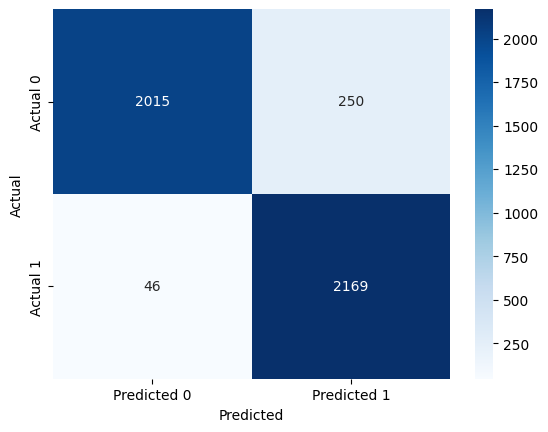

In [39]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_classes,)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()